In [44]:
#exam dec 2022
from skimage import io, color
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.decomposition import PCA
from skimage.transform import SimilarityTransform
from skimage.transform import warp
import os
import pathlib
import pydicom as dicom
from skimage.morphology import binary_erosion, binary_dilation
from skimage.morphology import disk
from skimage import measure, io
from scipy.spatial import distance
import SimpleITK as sitk
from math import radians, cos, sin

In [45]:
def minimum_distance_classification(values1, values2):
    #compute the mean of the values of each class
    values1_mean = np.mean(values1)
    values2_mean = np.mean(values2)


    #compute the thresholds
    t_background = -200 #decided by me
    thresh = (values1_mean + values2_mean)/2
    return thresh

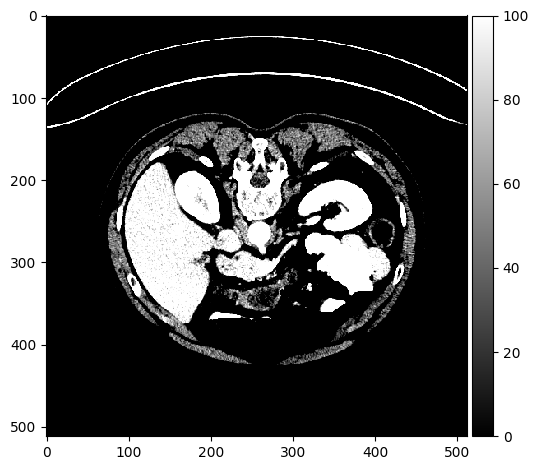

135.53619417264818
196.7035801627044


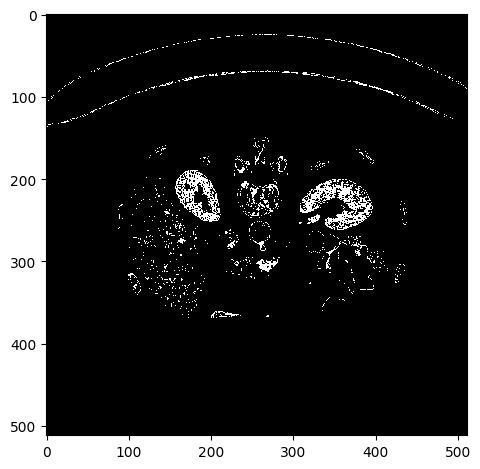

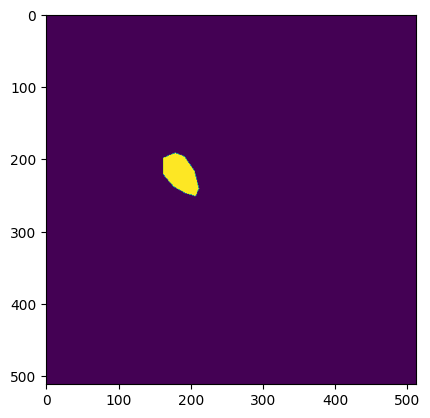

DICE score 0.24143337066069426


In [46]:
#dicom
dcm = dicom.read_file('./dec2022/data/dicom/1-162.dcm')
img = dcm.pixel_array #extract pixel data, already hounsfield units -> its the format for dicom images
io.imshow(img, vmin=0, vmax=100, cmap='gray')
io.show()

#extract pixel values
aorta_roi = io.imread('./dec2022/data/dicom/AortaROI.png')
aorta_mask = aorta_roi > 0 #white values
aorta_values = img[aorta_mask] #spleen values contain the HU values (HU values are the pixel value for DICOM images, )

back_roi = io.imread('./dec2022/data/dicom/BackROI.png')
back_mask = back_roi > 0 #white values
back_values = img[back_roi] #spleen values contain the HU values

k_roi = io.imread('./dec2022/data/dicom/KidneyROI.png')
k_mask = k_roi > 0 #white values
k_values = img[k_mask] #spleen values contain the HU values

liver_roi = io.imread('./dec2022/data/dicom/LiverROI.png')
liver_mask = liver_roi > 0 #white values
liver_values = img[liver_mask] #spleen values contain the HU values


t_1 = minimum_distance_classification(liver_values, k_values)
t_2 = minimum_distance_classification(aorta_values, k_values)

print(t_1)
print(t_2)

bin_dcm = (img > t_1) & (img < t_2)
io.imshow(bin_dcm)
io.show()

#compare founnd blobs with bloodGT image

plt.imshow(k_roi)
plt.show()

dice_score = 1 - distance.dice(bin_dcm.ravel(), k_roi.ravel())
print(f"DICE score {dice_score}")


In [47]:
#hough space

data = [(7,13), (9,10), (6,10), (6,8), (3,6)]
rho = 0.29
theta = 151
theta_rad = radians(151)

for (x,y) in data:
    print(x, y)
    #r = x*cos(theta_rad) + y*sin(theta_rad)
    y_new = rho/sin(theta_rad) - x*cos(theta_rad)/sin(theta_rad)
    print(y_new)


7 13
13.226507235391884
9 10
16.83460274593473
6 10
11.42245948012046
6 8
11.42245948012046
3 6
6.01031621430619


In [48]:
#compute accumulator image
def compute_accumulator(image):
    """
    Compute the accumulator image according to the provided definition.
    
    Parameters:
        image (numpy.ndarray): Input image.
        
    Returns:
        numpy.ndarray: Accumulator image.
    """
    # Initialize the accumulator image with the same shape as the input image
    accumulator = np.zeros_like(image, dtype=np.uint8)
    accumulator[0, :] = image[0, :]
    # Iterate over each row of the image to compute the accumulator
    for r in range(1, accumulator.shape[0]):
        for c in range(accumulator.shape[1]):
            # Compute the minimum value among the three adjacent pixels in the previous row
            min_value = np.inf
            if r > 0:
                for dc in [-1, 0, 1]:
                    if 0 <= c + dc < accumulator.shape[1]:
                        min_value = min(min_value, accumulator[r - 1, c + dc])
            
            # Update the accumulator value at the current pixel
            accumulator[r, c] = image[r, c] + min_value
    
    return accumulator


img = np.array([
    [64, 94, 21, 19, 31],
    [38, 88, 30, 23, 92],
    [81, 55, 47, 17, 43],
    [53, 62, 47, 17, 43],
    [35, 59, 84, 44, 90] 
    ])

accumulator_image = compute_accumulator(img)
accumulator_image



array([[ 64,  94,  21,  19,  31],
       [102, 109,  49,  42, 111],
       [183, 104,  89,  59,  85],
       [157, 151, 106,  76, 102],
       [186, 165, 160, 120, 166]], dtype=uint8)

In [49]:
from skimage.filters import threshold_otsu

def show_comparison(original, transformed, transformed_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.imshow(original, cmap = "gray")
    ax1.set_title("Original")
    ax1.axis("off")
    ax2.imshow(transformed, cmap = "gray")
    ax2.set_title(transformed_name)
    ax2.axis("off")
    io.show()

0.37246096


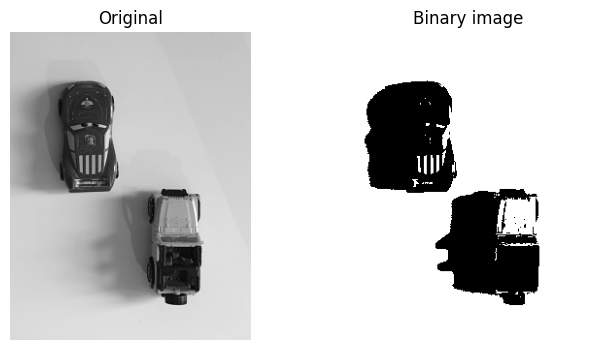

In [50]:
#pixelwise operations
car_im = io.imread("./dec2022/data/PixelWiseOps/pixelwise.png")
car_gray = color.rgb2gray(car_im)
car_f  = car_gray.astype(np.float32) / 255.0  # Assuming 8-bit depth (0-255)

min_desired = 0.1
max_desired = 0.6
min_val = car_f.min()
max_val = car_f.max()
	
img_out = ((max_desired - min_desired)/(max_val - min_val)) * (car_f - min_val) + min_desired

thresh = threshold_otsu(img_out)
print(thresh)
lights_bin = img_out > thresh 
show_comparison(car_f, lights_bin, 'Binary image')

In [51]:
from skimage import filters

In [192]:
rocket = io.imread("./dec2022/data/Filtering/rocket.png")
im_edges = filters.prewitt(img_as_ubyte(rocket))
bin_im = im_edges > 0.06

bin_im.sum()


23484

In [61]:
def LDA(X, y):
    """
    Linear Discriminant Analysis.

    A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
    Assumes equal priors among classes

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Training data
    y : array-like of shape (n_samples,)
        Target values.

    Returns
    -------
    W : array-like of shape (n_classes, n_features+1)
        Weights for making the projection. First column is the constants.

    Last modified: 11/11/22, mcbo@dtu.dk
    """
    
    # Determine size of input data
    n, m = X.shape
    # Discover and count unique class labels
    class_label = np.unique(y)
    k = len(class_label)

    # Initialize
    n_group     = np.zeros((k,1))     # Group counts
    group_mean  = np.zeros((k,m))     # Group sample means
    pooled_cov  = np.zeros((m,m))     # Pooled covariance
    W          = np.zeros((k,m+1))    # Model coefficients

    for i in range(k):
        # Establish location and size of each class
        group      = np.squeeze(y == class_label[i])
        n_group[i]  = np.sum(group.astype(np.double))
        
        # Calculate group mean vectors
        group_mean[i,:] = np.mean(X[group,:], axis = 0)
        
        # Accumulate pooled covariance information
        pooled_cov = pooled_cov + ((n_group[i] - 1) / (n - k) ) * np.cov(X[group,:], rowvar = False)
    
    # Assign prior probabilities
    prior_prob = n_group / n

    # Loop over classes to calculate linear discriminant coefficients
    for i in range(k):
        # Intermediate calculation for efficiency
        temp = group_mean[i,:][np.newaxis] @ np.linalg.inv(pooled_cov)
        
        # Constant
        W[i,0] = -0.5 * temp @ group_mean[i,:].T + np.log(prior_prob[i])
        
        # Linear
        W[i,1:] = temp

    return W


In [86]:
mean1 = [24,3]
mean2 = [30,7]

group_mean = np.array(([24, 3], [30, 7]))
diff = group_mean[1, :] - group_mean[0,:]
print(diff)
x_diff = diff[:, None]
print(x_diff)

cov = np.array([[2, 0], [0, 2]])

w = np.linalg.inv(cov) @  x_diff
print(w)
#c = ln(p1/p2) - 0.5(mean2 + mean1)
c = -0.5 * np.sum(group_mean, axis=0,  keepdims=True)
print(c)
w0 = c @ w
print(f"w0 : {w0}")

x = np.array([23,5])
y = x.T @ w + w0

if x.T @ w < w0:
    print("class 2")
else:
    print("class 1")
print(y)


[6 4]
[[6]
 [4]]
[[3.]
 [2.]]
[[-27.  -5.]]
w0 : [[-91.]]
class 1
[[-12.]]


In [91]:
from skimage.filters import gaussian
from scipy.stats import norm

In [93]:
Cows = [26, 46, 33, 23, 35, 28, 21, 30, 38, 43]
Sheep = [67, 27, 40, 60, 39, 45, 27, 67, 43, 50, 37, 100]

thresh_cs = minimum_distance_classification(Cows, Sheep)
print(thresh_cs)

mu_cows, std_cows = norm.fit(Cows)
mu_sheep, std_sheep = norm.fit(Sheep)


test_val = 38
cow_prob = norm.pdf(test_val, mu_cows, std_cows)
sheep_prob = norm.pdf(test_val, mu_sheep, std_sheep)
print(f"Cow probability {cow_prob:.2f}")
print(f"Sheep probability {sheep_prob:.2f}")





41.233333333333334
Cow probability 0.04
Sheep probability 0.02


In [94]:
from skimage import color, io, measure, img_as_ubyte
from skimage.measure import profile_line
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize
from skimage import segmentation
import matplotlib.pyplot as plt
import numpy as np
import pydicom as dicom
import seaborn as sns
import pandas as pd
from sklearn import decomposition

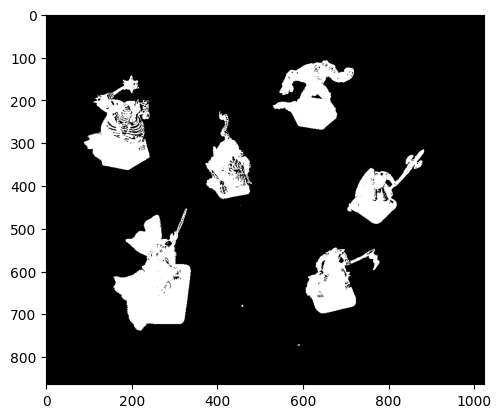

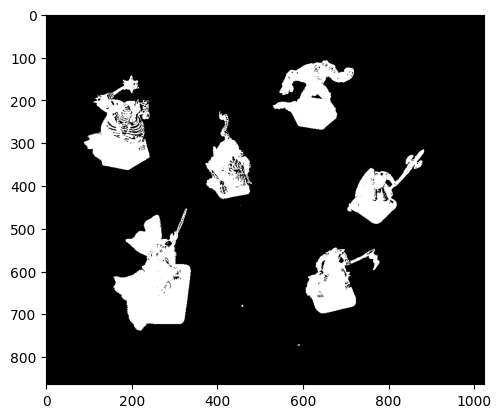

In [100]:
figures = io.imread("./dec2022/data/BLOBs/figures.png")
fig_gray = color.rgb2gray(figures)
thresh = threshold_otsu(fig_gray)
bin_im = fig_gray < thresh

plt.imshow(bin_im, cmap = "gray")
plt.show()

im_process = segmentation.clear_border(bin_im) #remove all border blobs
plt.imshow(im_process, cmap = "gray")
plt.show()

In [103]:
label_img = measure.label(im_process)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")# == number of blobs
region_props = measure.regionprops(label_img)

target_area = 13000
count = 0 
max_area = 0
max_perim = 0

label_img_filter = label_img.copy()
for region in region_props:
    area = region.area
    if area > target_area:
        count += 1
    if area > max_area:
        max_area = area
        max_perim = region.perimeter

print(max_perim)

Number of labels: 31
1998.3576105691297


In [146]:
#attributes = [wheel-base, length, width, height, curb-weight, engine-size, horsepower and highway-mpg]

car_data = np.loadtxt('./dec2022/data/CarPCA/car_data.txt',  comments="%")
print(car_data)
x = car_data
n_feat = x.shape[1]
n_obs = x.shape[0]

mean = np.mean(x, axis = 0)  #computes mean of each feature
data_matrix = x - mean
std = np.std(data_matrix, axis = 0)
data_matrix = data_matrix / std #normalized

print(data_matrix.shape)

cov_mat = np.cov(data_matrix.T)

print(cov_mat.shape)

print(data_matrix[0][0])
car_pca = PCA()
car_pca.fit(data_matrix)

explained_variance = car_pca.explained_variance_ratio_
print(explained_variance[0] + explained_variance[1])

[[ 88.6 168.8  64.1 ... 130.  111.   27. ]
 [ 88.6 168.8  64.1 ... 130.  111.   27. ]
 [ 94.5 171.2  65.5 ... 152.  154.   26. ]
 ...
 [109.1 188.8  68.9 ... 173.  134.   23. ]
 [109.1 188.8  68.9 ... 145.  106.   27. ]
 [109.1 188.8  68.9 ... 141.  114.   25. ]]
(203, 8)
(8, 8)
-1.6884672145358348
0.8655230020532865


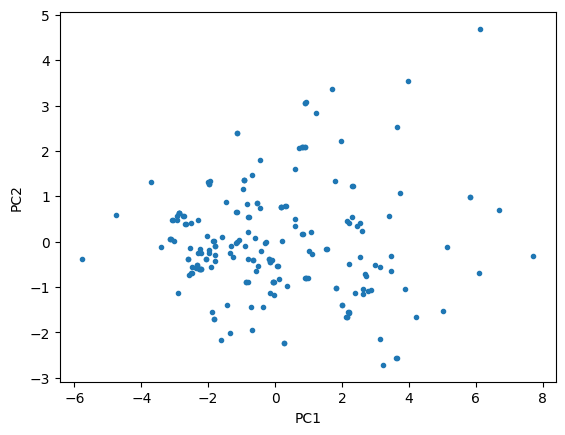

1.128239339104287


In [136]:
#projecting onto first 2 principal components:
components = car_pca.transform(data_matrix)
pc_1 = components[:, 0]
pc_2 = components[:, 1]

plt.plot(pc_1, pc_2, '.')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

max_index = np.argmax(pc_1)
min_index = np.argmin(pc_1)

first_val = pc_1[0]
print(np.abs(first_val))


<Figure size 640x480 with 0 Axes>

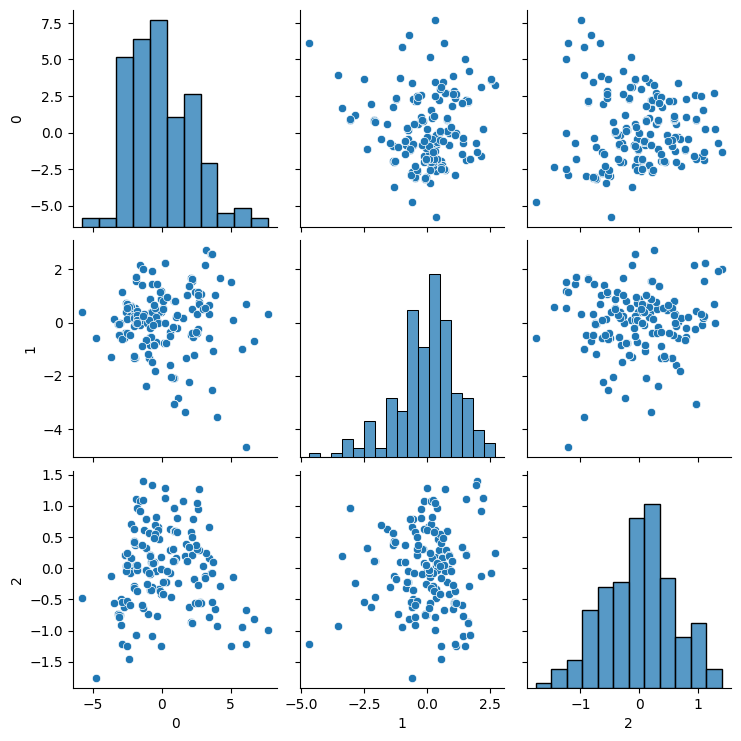

In [148]:
  # Project data
values, vectors = np.linalg.eig(cov_mat)
pc_proj = vectors.T.dot(data_matrix.T)
pc_proj_red = pc_proj[0:3, :]
# pc_proj_red = pc_proj[5:8, :]

    # Answer 3
plt.figure()
    # Transform the data into a Pandas dataframe
d = pd.DataFrame(pc_proj_red.T)
sns.pairplot(d)
    # plt.savefig('pairplot_5.png')
plt.show()

In [150]:
from skimage.transform import EuclideanTransform, matrix_transform

Landmark alignment error F (sum of squared differences): 67021
Landmark alignment error F (sum of squared differences): 21119.638667058487


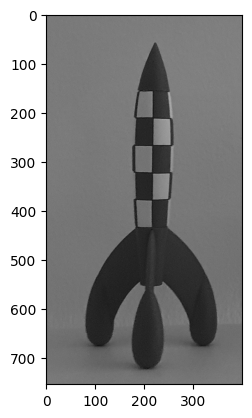

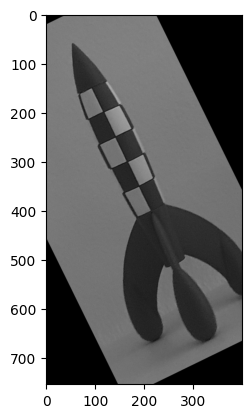

[129 129 129]


In [155]:
#landmark based reg
src = np.array([(220, 55), (105, 675), (315, 675)])
dst = np.array([(100, 165), (200, 605), (379, 525)])

e_x = src[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f = error_x + error_y
print(f"Landmark alignment error F (sum of squared differences): {f}")

tform = EuclideanTransform()
tform.estimate(src, dst)
src_transform = matrix_transform(src, tform.params) 

e_x = src_transform[:, 0] - dst[:, 0]
error_x = np.dot(e_x, e_x)
e_y = src_transform[:, 1] - dst[:, 1]
error_y = np.dot(e_y, e_y)
f_after = error_x + error_y
print(f"Landmark alignment error F (sum of squared differences): {f_after}")

rocket = io.imread("./dec2022/data/Filtering/rocket.png")

warped_im = warp(rocket, tform.inverse)
warped_im = img_as_ubyte(warped_im)
plt.imshow(rocket)
plt.show()
plt.imshow(warped_im)
plt.show()

print(warped_im[150][150])


In [158]:
#remove noise
sigma = 3
gauss1 = gaussian(rocket, sigma)
byte_img = img_as_ubyte(gauss1)
print(byte_img[100][100])

[123 123 123]


In [159]:
from skimage.transform import rotate

In [162]:
cphsun = io.imread('./dec2022/data/GeomTrans/CPHSun.png')
angle = 16
center = (20, 20)
rotated = rotate(cphsun, angle, center = [20, 20])
rotated = img_as_ubyte(rotated)

rotated[200][200]

array([88, 91, 95], dtype=uint8)

In [166]:
pixelwise = io.imread('./dec2022/data/PixelWiseOps/pixelwise.png')
hsv_im = color.rgb2hsv(pixelwise)
s_im = hsv_im[:,:,1]
pw_thresh = threshold_otsu(s_im)
pw_bin = s_im > pw_thresh

footprint = disk(4)
eroded = binary_erosion(pw_bin, footprint)

eroded.sum()

10045

In [181]:
#video change detection
im1 = io.imread('./dec2022/data/ChangeDetection/change1.png')
im2 = io.imread('./dec2022/data/ChangeDetection/change2.png')

transfer_speed = 30 * 10**6 #bytes /second
im_size = 1024 * 768 * 3 #bytes/image
proc_time = 54 * 10**-3 #seconds / image

proc_fps = 1 / proc_time
print(proc_fps)
frame_rate = transfer_speed / im_size

print(min(proc_fps, frame_rate))


18.51851851851852
12.715657552083334


In [190]:
im1_gray = color.rgb2gray(im1)
im2_gray = color.rgb2gray(im2)

diff_im = np.abs(im1_gray - im2_gray)
bin_im = (diff_im > 0.3)
changed_pixels = np.sum(bin_im)
print(changed_pixels)
percentage = changed_pixels / bin_im.size * 100

print(f"{percentage:.2f}")

7503
4.56
